# Roman/Rubin Observing Season Complementarity

The near-IR Nancy Grace Roman Space Telescope and the optical Vera C. Rubin Observatory both have the capacity to deliver deep limiting magnitude, high spatial resolution, timeseries photometry at complementary wavelengths.  This notebook explores how coordinating the observing schedules of these facility could be scientifically beneficial and outlines a metric for evaluating and optimizing complementary scheduling.  

This notebook specifically explores the scheduling of the Roman Galactic Bulge Time Domain Survey, but the metric is designed such that the same principle could be applied to other survey regions as well.  

In [46]:
from os import path
from roman_mission import RomanGalBulgeSurvey
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import rubin_visibility
import rubin_sim.maf as maf
from rubin_sim.utils import (
    hpid2_ra_dec,
    angular_separation,
)
import healpixel_functions
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

In [2]:
NSIDE=64

## Roman Galactic Bulge Time Domain Survey (RGBTDS)

Roman is expected to observe the Galactic Bulge in seasons of approximately 60-70d long.  Due to pointing constraints of this telescope, these seasons will occur between February to April and August to October.  A total of ~6 seasons are anticipated, although the exact scheduling of these seasons is still to be determined.  Assuming the facility is launched on schedule in 2025 the first such season could take place, post-launch testing phase, in 2026.  

For the purposes of exploration, nominal dates for the RGBTDS seasons are defined with the following function.  
(Note: this produces warnings because future leap seconds are undefined; this does not significantly impact these calculations).

In [3]:
roman_survey = RomanGalBulgeSurvey()
print('Dates of nominal RGBTDS seasons: ')
for season in roman_survey.seasons:
    print(season)
print('Dates of season gaps:')
for gap in roman_survey.season_gaps:
    print(gap)

Dates of nominal RGBTDS seasons: 
{'start': <Time object: scale='utc' format='isot' value=2026-02-12T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2026-04-24T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2026-09-19T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2026-10-29T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2027-02-12T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2027-04-24T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2027-09-19T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2027-10-29T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2028-02-12T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2028-04-24T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2028-09-19T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2028-10-29T00:00:00.000>}


/Users/rstreet1/opt/miniconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/rstreet1/opt/miniconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## Rubin Observatory

Rubin Observatory is expected to start science operations in mid-2025 [see https://www.lsst.org/about/project-status], which for the sake of these calculations we take to be July 2025.  It will then spend 10 yrs conducting the Legacy Survey of Space and Time (LSST), which will survey the whole Southern Sky in 6 Sloan filters.  The exact cadence with which different areas of the survey footprint will be surveyed is a work in progress, combining many different science goals.  Many simulations of Rubin operations ("OpSimS") have been conducted exploring alternative strategies, and the current nominal strategy is described by opsim baseline_3.0.  

For our purposes, the important aspect of this opsim is that it includes timeseries observations of the RGBTDS footprint.  

The timestamps of the observations realized in any given strategy can be extracted from the opsim database using [Rubin's Metric Analysis Framework](https://www.lsst.org/scientists/simulations/maf) (MAF).  

## Inter-season Observations Metric

There will typically be gaps between sequential seasons of Roman observations of the Bulge.  These gaps will be at least several months long and potentially may exceed 1yr.  This means that the lightcurves of transient phenomena, including microlensing, will be partially sampled, in cases where the peak of the event occurs close to a season boundary.  This is particularly important for long-baseline events, such as those caused by black hole lenses, since regular sampling of the lightcurves is important to constrain parameters such as the microlensing parallax.  

The long baseline of LSST means that it could provide regular, if lower cadence, photometry of stars within the RGBTDS footprint during the inter-season gaps.  

The following metric is designed to run within the Rubin Observatory's MAF framework.  

In [12]:
class RomanRubinInterSeasonObsMetric(maf.metrics.BaseMetric):
    """Metric to evaluate whether LSST will provide observations during the 
    inter-season gaps in the Roman Galactic Bulge Time Domain Survey (RGBTDS).
    
    This metric calculates the median interval between sequential Rubin 
    observations in any filter, for all dates within the RGBTDS season gaps.  
    A signal-to-noise selection cut is applied to include only high limiting 
    magnitude observations.  
    
    The metric value returned represents the mean of this statistic over all season gaps. 
    """
    
    def __init__(self, 
                 time_col='observationStartMJD',
                 ra_col='fieldRA', 
                 dec_col='fieldDec', 
                 filter_col='filter',
                 mag_cuts=None,
                 nside=64,
                 metricName='RomanRubinInterSeasonObsMetric',
                 m5Col='fiveSigmaDepth',
                 **kwargs):
        
        # Store the column names of OpSim data columns for later use. 
        # Note a magnitude cut is applied to ensure that only high S/N observations are included.  
        # Although this is filter bandpass dependant, it simplifies the code considerably to consider 
        # a minimum value across all filters, with little loss of accuracy.
        self.ra_col = ra_col
        self.dec_col = dec_col
        self.mjdCol = time_col
        self.m5Col = m5Col
        self.filters = ['u','g', 'r', 'i', 'z', 'y']
        self.filter_col = filter_col
        if mag_cuts is not None:
            self.mag_cuts = mag_cuts
        else:
            self.mag_cuts = {
                "u": 22.7,
                "g": 24.1,
                "r": 23.7,
                "i": 23.1,
                "z": 22.2,
                "y": 21.4,
            }
        self.nside = nside
        col_list = [self.ra_col, self.dec_col, self.mjdCol, self.m5Col, self.filter_col]
        
        # Define the default threshold of the median interval [in days] between successive observations within 
        # a season gap.  If the calculated metric is less than this threshold, the 
        # gap is considered to be monitored in the Rubin data.  This threshold is set very loose deliberately, 
        # in order to compare survey strategies which may provide only limited numbers of visits
        self.max_interval = 3.0
        
        # Load information on the nominal RGBTDS observing seasons and field location
        self.roman_survey = RomanGalBulgeSurvey()
        
        super(RomanRubinInterSeasonObsMetric, self).__init__(col=col_list)
    
        # Declare the metric as object type, in order to return an array of values:
        self.metric_dtype = "object"
        
    def run(self, data_slice, slice_point):
        
        # Rubin seasonal visibility
        # Due to the Roman pointing constraints, it is likely that some inter-season gaps will occur during
        # times when the Bulge cannot be seen from the Earth.  Although this metric is calculated for all 
        # season gaps, it is expected that no Rubin coverage is possible in some cases.  Here we identify which 
        # seasons should be observable
        gap_visibility = []
        for gap in self.roman_survey.season_gaps:
            tmid = gap['start'] + ((gap['end']-gap['start'])/2.0)
            dates = [gap['start'], tmid, gap['end']]
            visibility_table = rubin_visibility.visibility_over_date_range(self.roman_survey.bulge_field, dates)
            gap_visibility.append( (np.array(visibility_table) > 0.0).all() )

        # For all sky pointings provided in the dataSlice, calculate the number of hours per night
        # for which Rubin can observe that sky pointing for dates between the start and end 
        # of the gaps between RGBTDS observing seasons
        dt = TimeDelta(1, format='jd', scale=None)
        metric_data = {}
        for bandpass in self.filters:
            idx1 = np.where(data_slice[self.filter_col] == bandpass)[0]

            metric = []
            for gap in self.roman_survey.season_gaps:

                # Get array of dates within the season gap, at intervals of 1 night
                deltagap = gap['end'] - gap['start']
                ndates = np.ceil((deltagap/dt).value)
                dates = gap['start'] + dt * np.arange(0, ndates, 1)

                # Fetch the timestamps of high S/N Rubin observations that occur within the Roman data gap
                # OpSim JDs are stored as MJDs, so we adjust the gap start/end dates accordingly 
                idx2 = np.where(data_slice[self.mjdCol] >= (gap['start'].jd - 2400000.0))[0]
                idx3 = np.where(data_slice[self.mjdCol] <= (gap['end'].jd - 2400000.0))[0]
                idx4 = np.where(data_slice[self.m5Col] >= self.mag_cuts[bandpass])[0]
                idx = set(idx1).intersection(set(idx2))
                idx = idx.intersection(set(idx3))
                gap_obs_index = list(idx.intersection(set(idx4)))
                
                tobs_ordered_gap = data_slice[gap_obs_index][self.mjdCol]
                tobs_ordered_gap.sort()

                # If no observations occur within the gap, we set the metric value NaN
                if len(gap_obs_index) <= 1:
                    metric.append(np.nan)
                else:

                # Calculate the median interval between sequential Rubin observations in any filter
                # in the Roman season gap:
                    delta_tobs = tobs_ordered_gap[1:] - tobs_ordered_gap[0:-1]
                    metric.append(np.median(delta_tobs))

            # Metrics calculated:
            # Median metric over all visible season gaps for this filter
            # Store the inter-season gap medians for all gaps
            # Number of seasons which have medians lower than the default threshold
            metric = np.array(metric)
            ngaps_monitored = len(np.where(metric[gap_visibility] <= self.max_interval)[0])
            metric_data[bandpass] = {'median': np.median(metric[gap_visibility]),
                                     'seasonal_median': metric,
                                     'ngaps_monitored': ngaps_monitored,
                                     'ngaps': len(self.roman_survey.season_gaps)}

        return metric_data
    

/Users/rstreet1/software/rubin_sim/rubin_sim/maf/metrics/base_metric.py:37: UserWarning: Redefining metric __main__.RomanRubinInterSeasonObsMetric! (there are >1 metrics with the same name)
  warnings.warn(


As an example, we can apply this metric to a simulation of Rubin's current baseline survey strategy, known as baseline_v3.0.  

In [13]:
opsim_db_file = '/Users/rstreet1/rubin_sim_data/sim_baseline/baseline_v3.0_10yrs.db'
runName = path.split(opsim_db_file)[-1].replace('.db', '')

# Load the OpSim database
#opsim_db = maf.OpsimDatabase(opsim_db_file)

Since this metric is only defined for the Roman Bulge survey region, it make sense to run this code using a HEALpixsubsetslicer, which makes calculations for a selected set of HEALpixels, rather than the default all-sky slicer.  (This is based on an example from the MAF team: https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/batches/ddf_batch.py#L66)

In [14]:
# Build HEALpix subset slicer.  
# Starting with a list of the RA, Dec of all HEALpix, select only those within the radius of a 
# Rubin FOV of the center of the RGBTDS footprint
ra, dec = hpid2_ra_dec(NSIDE, np.arange(hp.nside2npix(NSIDE)))
radius = 3.5/2.0 # Rubin FOV radius
dist = angular_separation(ra, dec, [roman_survey.bulge_field.ra.value], [roman_survey.bulge_field.dec.value])
goods = np.where(dist <= radius)[0]
slicer = maf.HealpixSubsetSlicer(NSIDE, goods, use_cache=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Run the metric calculations for all HEALpixels

In [15]:
bundleList = []
metric1 = RomanRubinInterSeasonObsMetric()
constraint = 'fiveSigmaDepth > 21.5'
#slicer = maf.slicers.HealpixSlicer(nside=64, useCache=False)
plotDict = {'colorMax': 950}
bundleList.append(maf.MetricBundle(metric1, slicer, constraint, run_name=runName))
#bundleDict = maf.metricBundles.makeBundlesDictFromList(bundleList)
bundleGroup = maf.MetricBundleGroup(bundleList, opsim_db_file, out_dir='metric_results', results_db=None)
bundleGroup.run_all()

Now we can unpack the metric values.  Since a HEALpixSlicer is normally used with science metrics, the returned array will be NPIX long, but the value we are interested in is that for the HEALpix containing the RGBTDS survey field

In [16]:
def unpack_metric_data(bundle):
    bulge_hp = healpixel_functions.skycoord_to_HPindex(roman_survey.bulge_field, 64)[0]
    metric_data = {}
    for bandpass in ['u','g', 'r', 'i', 'z', 'y']:
        data = bundle.metric_values
        metric_data[bandpass] = data[bulge_hp][bandpass]
    return metric_data

In [17]:
metric_data = {runName: unpack_metric_data(bundleList[0])}
print(metric_data)

{'baseline_v3.0_10yrs': {'u': {'median': nan, 'seasonal_median': array([      nan,       nan, 0.4601694,       nan,       nan]), 'ngaps_monitored': 1, 'ngaps': 5}, 'g': {'median': 14.952295869003137, 'seasonal_median': array([17.17214893,         nan, 14.95229587,         nan,  5.49724804]), 'ngaps_monitored': 0, 'ngaps': 5}, 'r': {'median': 2.1548218241732684, 'seasonal_median': array([ 2.15482182,         nan,  2.01770084,         nan, 23.92082941]), 'ngaps_monitored': 2, 'ngaps': 5}, 'i': {'median': 10.89887273653585, 'seasonal_median': array([16.44625518,         nan,  2.54389274,         nan, 10.89887274]), 'ngaps_monitored': 1, 'ngaps': 5}, 'z': {'median': 22.955033071488288, 'seasonal_median': array([23.42396117,         nan,  0.99595938,         nan, 22.95503307]), 'ngaps_monitored': 1, 'ngaps': 5}, 'y': {'median': 3.4975129369886417, 'seasonal_median': array([3.49751294,        nan, 0.93444226,        nan, 9.37844587]), 'ngaps_monitored': 1, 'ngaps': 5}}}


We can run this metric for alternative Rubin survey strategies, for comparison.  

In [18]:
opsim_list = ['plane_priority_priority0.1_pbt_v2.1_10yrs.db', 
              'plane_priority_priority1.2_pbt_v2.1_10yrs.db',
              'rolling_bulge_ns2_rw0.9_v2.0_10yrs.db']

metric1 = RomanRubinInterSeasonObsMetric()
    
for sim in opsim_list:
    opsim_db_file = path.join('/Users/rstreet1/rubin_sim_data/sims/',sim)
    runName = path.split(opsim_db_file)[-1].replace('.db', '')
    
    bundleList = []
    constraint = 'fiveSigmaDepth > 21.5'
    bundleList.append(maf.MetricBundle(metric1, slicer, constraint, run_name=runName))
    bundleGroup = maf.MetricBundleGroup(bundleList, opsim_db_file, out_dir='metric_results', results_db=None)
    bundleGroup.run_all()
    
    metric_data[runName] = unpack_metric_data(bundleList[0])

In [19]:
metric_data

{'baseline_v3.0_10yrs': {'u': {'median': nan,
   'seasonal_median': array([      nan,       nan, 0.4601694,       nan,       nan]),
   'ngaps_monitored': 1,
   'ngaps': 5},
  'g': {'median': 14.952295869003137,
   'seasonal_median': array([17.17214893,         nan, 14.95229587,         nan,  5.49724804]),
   'ngaps_monitored': 0,
   'ngaps': 5},
  'r': {'median': 2.1548218241732684,
   'seasonal_median': array([ 2.15482182,         nan,  2.01770084,         nan, 23.92082941]),
   'ngaps_monitored': 2,
   'ngaps': 5},
  'i': {'median': 10.89887273653585,
   'seasonal_median': array([16.44625518,         nan,  2.54389274,         nan, 10.89887274]),
   'ngaps_monitored': 1,
   'ngaps': 5},
  'z': {'median': 22.955033071488288,
   'seasonal_median': array([23.42396117,         nan,  0.99595938,         nan, 22.95503307]),
   'ngaps_monitored': 1,
   'ngaps': 5},
  'y': {'median': 3.4975129369886417,
   'seasonal_median': array([3.49751294,        nan, 0.93444226,        nan, 9.37844587]),

Now to compare the results for the different OpSims

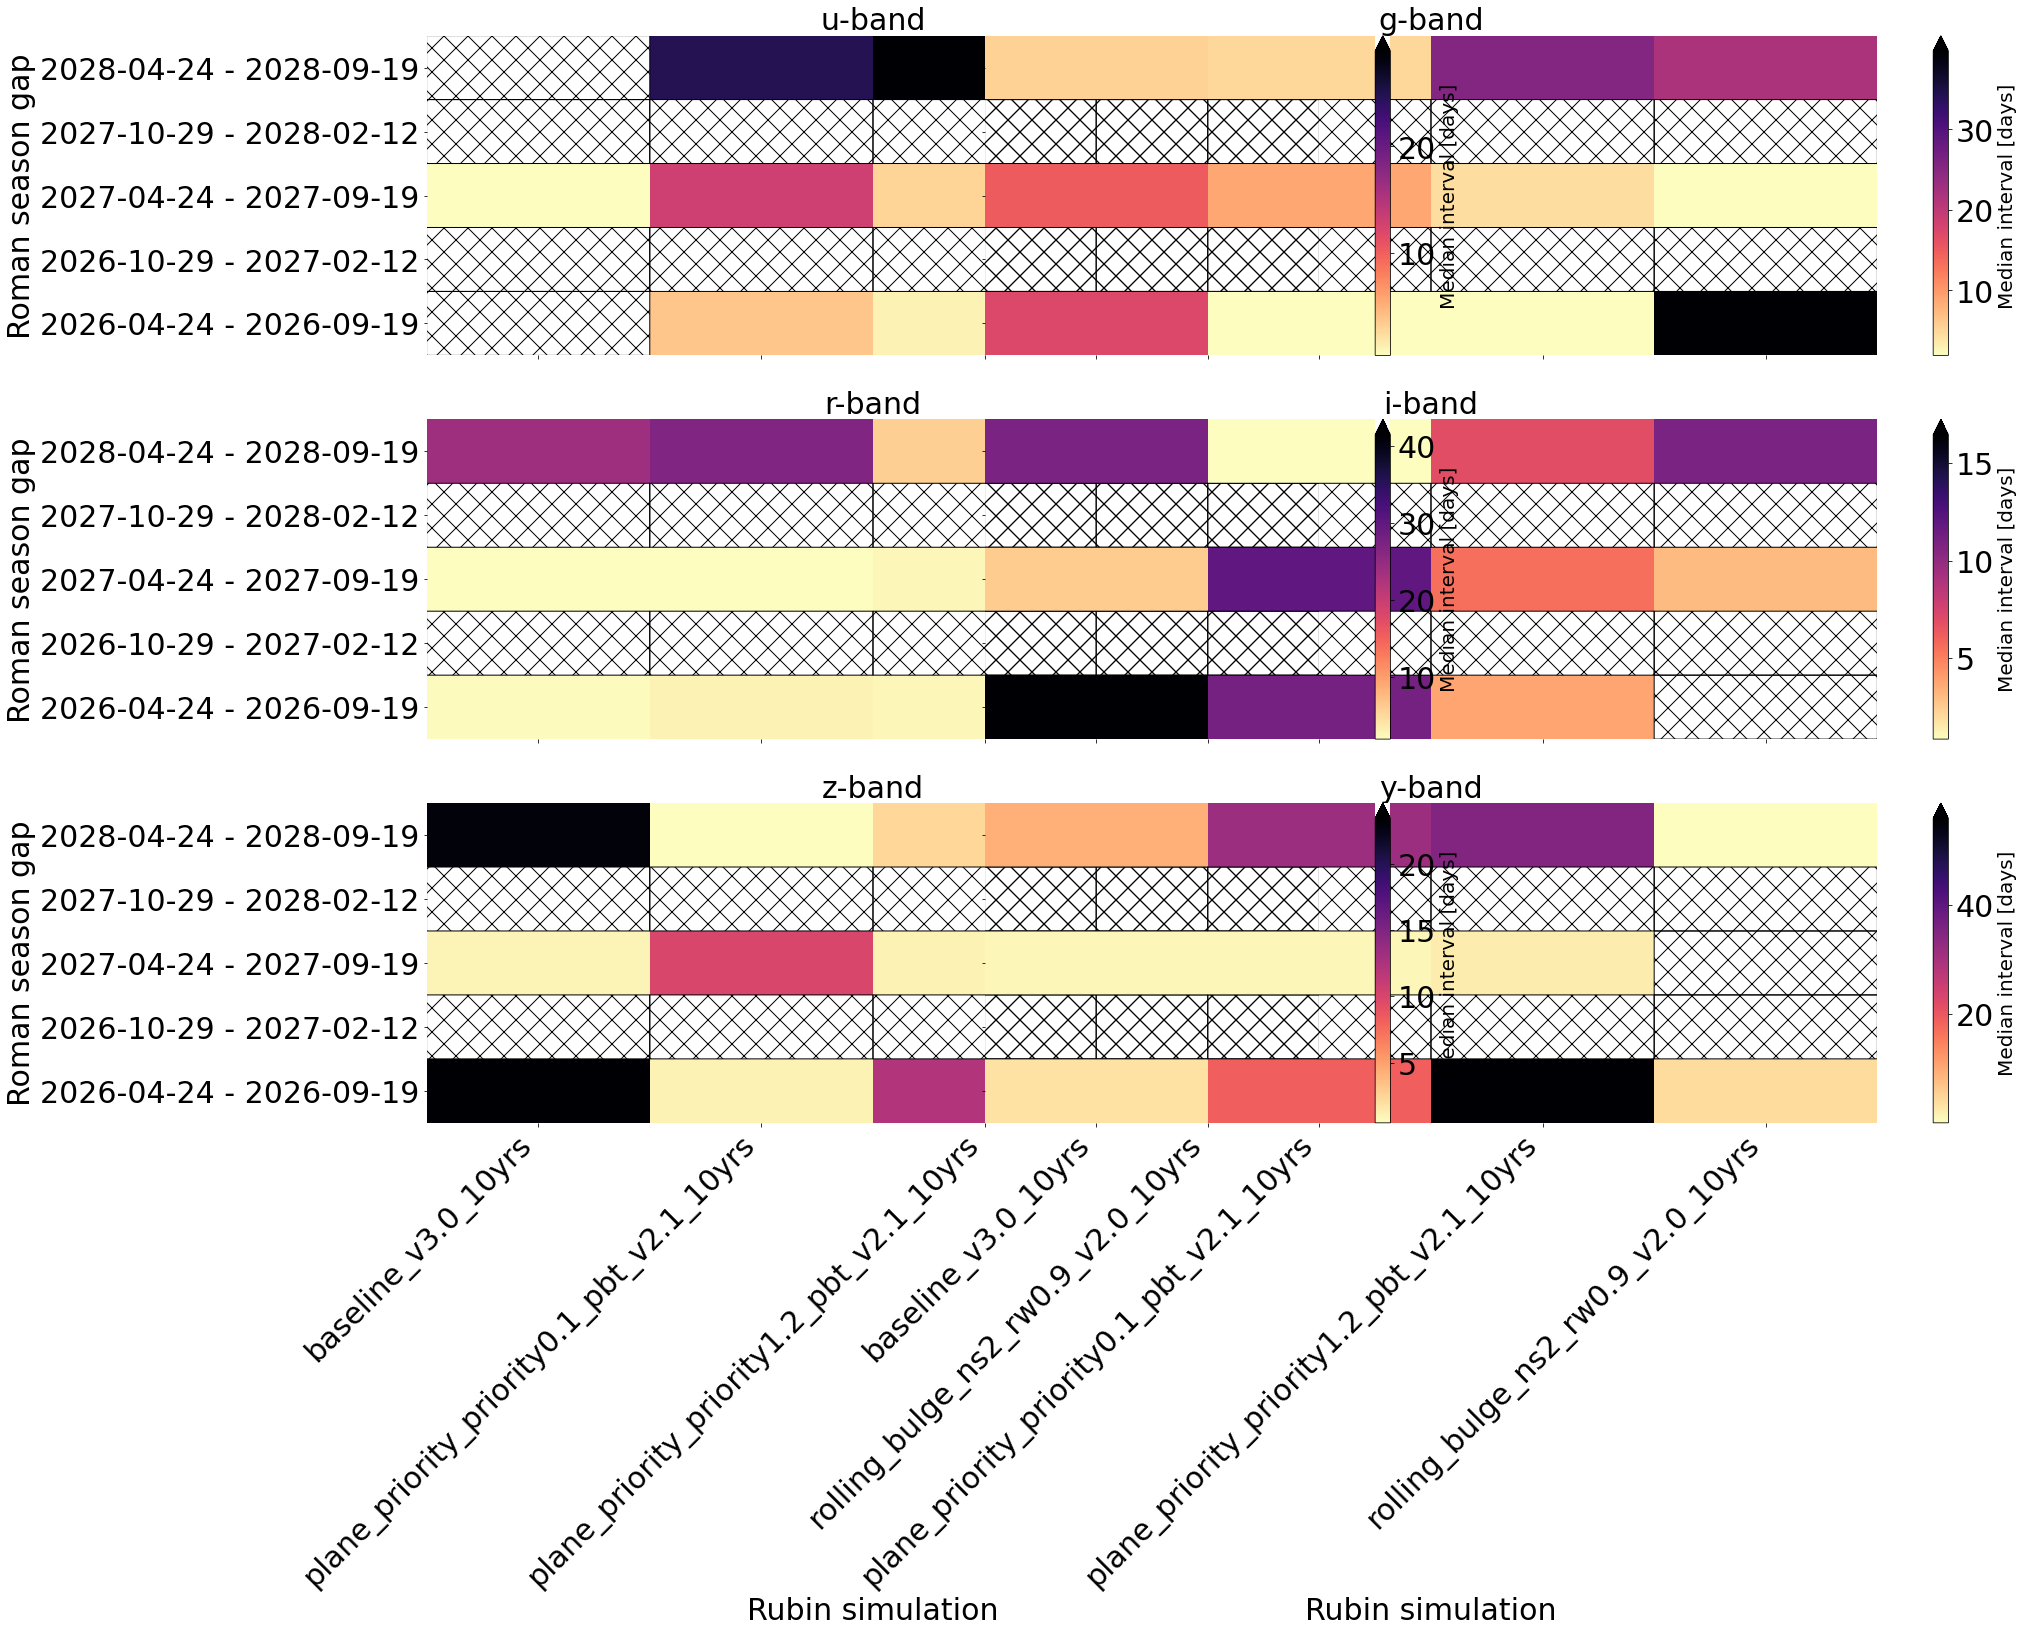

In [134]:
# Sort the list of opsims into alphabetical order
opsim_list = list(metric_data.keys())
opsim_list.sort()

# Build a list of the Roman season gaps to use as axis labels
seasongap_list = []
for gap in roman_survey.season_gaps:
    label = str(gap['start']).split('T')[0]+' - '+str(gap['end']).split('T')[0]
    seasongap_list.append(label)

nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(10*nrow,10*ncol), facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.5, hspace=None)

fontsize = 30

irow = 0
icol = -1
for f,bandpass in enumerate(['u','g','r','i','z','y']):
    icol += 1
    if icol >= ncol:
        icol = 0
        irow += 1
    ax = axs[irow,icol]
    #ax.set_facecolor("white")
    
    # Extract the data from all opsims into a 2D array to plot as a heatmap
    ngaps = len(roman_survey.season_gaps)
    data_grid = np.zeros( (ngaps,len(metric_data)) )
    for i,runName in enumerate(opsim_list):
        for j in range(0,ngaps,1):
            data_grid[j,i] = metric_data[runName][bandpass]['seasonal_median'][j]
    xgrid = np.arange(0,len(opsim_list)+1,1)
    ygrid = np.arange(0,ngaps+1,1)

    # Set color scaling
    cmap_reversed = mpl.cm.get_cmap('magma_r')
    norm = mpl.colors.Normalize(data_grid.min(), data_grid.max())

    # Plot heatmap
    pcm = ax.pcolormesh(xgrid, ygrid, data_grid, cmap=cmap_reversed,
                    vmin=np.nanmin(data_grid), vmax=np.nanmax(data_grid))

    # Mask out the NaN array entries
    mask = np.isnan(data_grid)
    for j, i in np.column_stack(np.where(mask)):
          ax.add_patch(
              mpatches.Rectangle(
                  (i, j),     # (x,y)
                  1,          # width
                  1,          # height
                  fill=False, 
                  edgecolor=None,
                  snap=False,
                  hatch='x' # the more slashes, the denser the hash lines 
              ))

    # Add plot labels
    ax.set_frame_on(False) # remove all spines
    ax.set_xticks(xgrid[0:-1]+0.5)
    ax.set_yticks(ygrid[0:-1]+0.5)
    
    # Include x-axis labels for the bottom row plots only
    if irow == nrow-1:
        ax.set_xlabel('Rubin simulation', fontsize=fontsize)
        ax.set_xticklabels(opsim_list,rotation=45.0,horizontalalignment='right',fontsize=fontsize)
    else:
        ax.set_xticklabels([])
        
    # Include y-axis labels for the first column plots only
    if icol == 0:
        ax.set_ylabel('Roman season gap', fontsize=fontsize)
        ax.set_yticklabels(seasongap_list,fontsize=fontsize,horizontalalignment='right')
    else:
        ax.set_yticklabels([])
        
    ax.set_title(bandpass+'-band', fontsize=fontsize)
    
    # Add a colorbar
    cb = fig.colorbar(pcm, ax=ax, extend='max')
    # Remove tick marks
    cb.ax.xaxis.set_tick_params(size=0)
    cb.ax.tick_params(labelsize=fontsize)
    # Set legend label
    cb.set_label('Median interval [days]', size=min(20,fontsize))

display = True
if display:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig('/Users/rstreet1/Roman/CoreSurveyWhitePaper/roman_rubin_metric.png')
    plt.close(1)

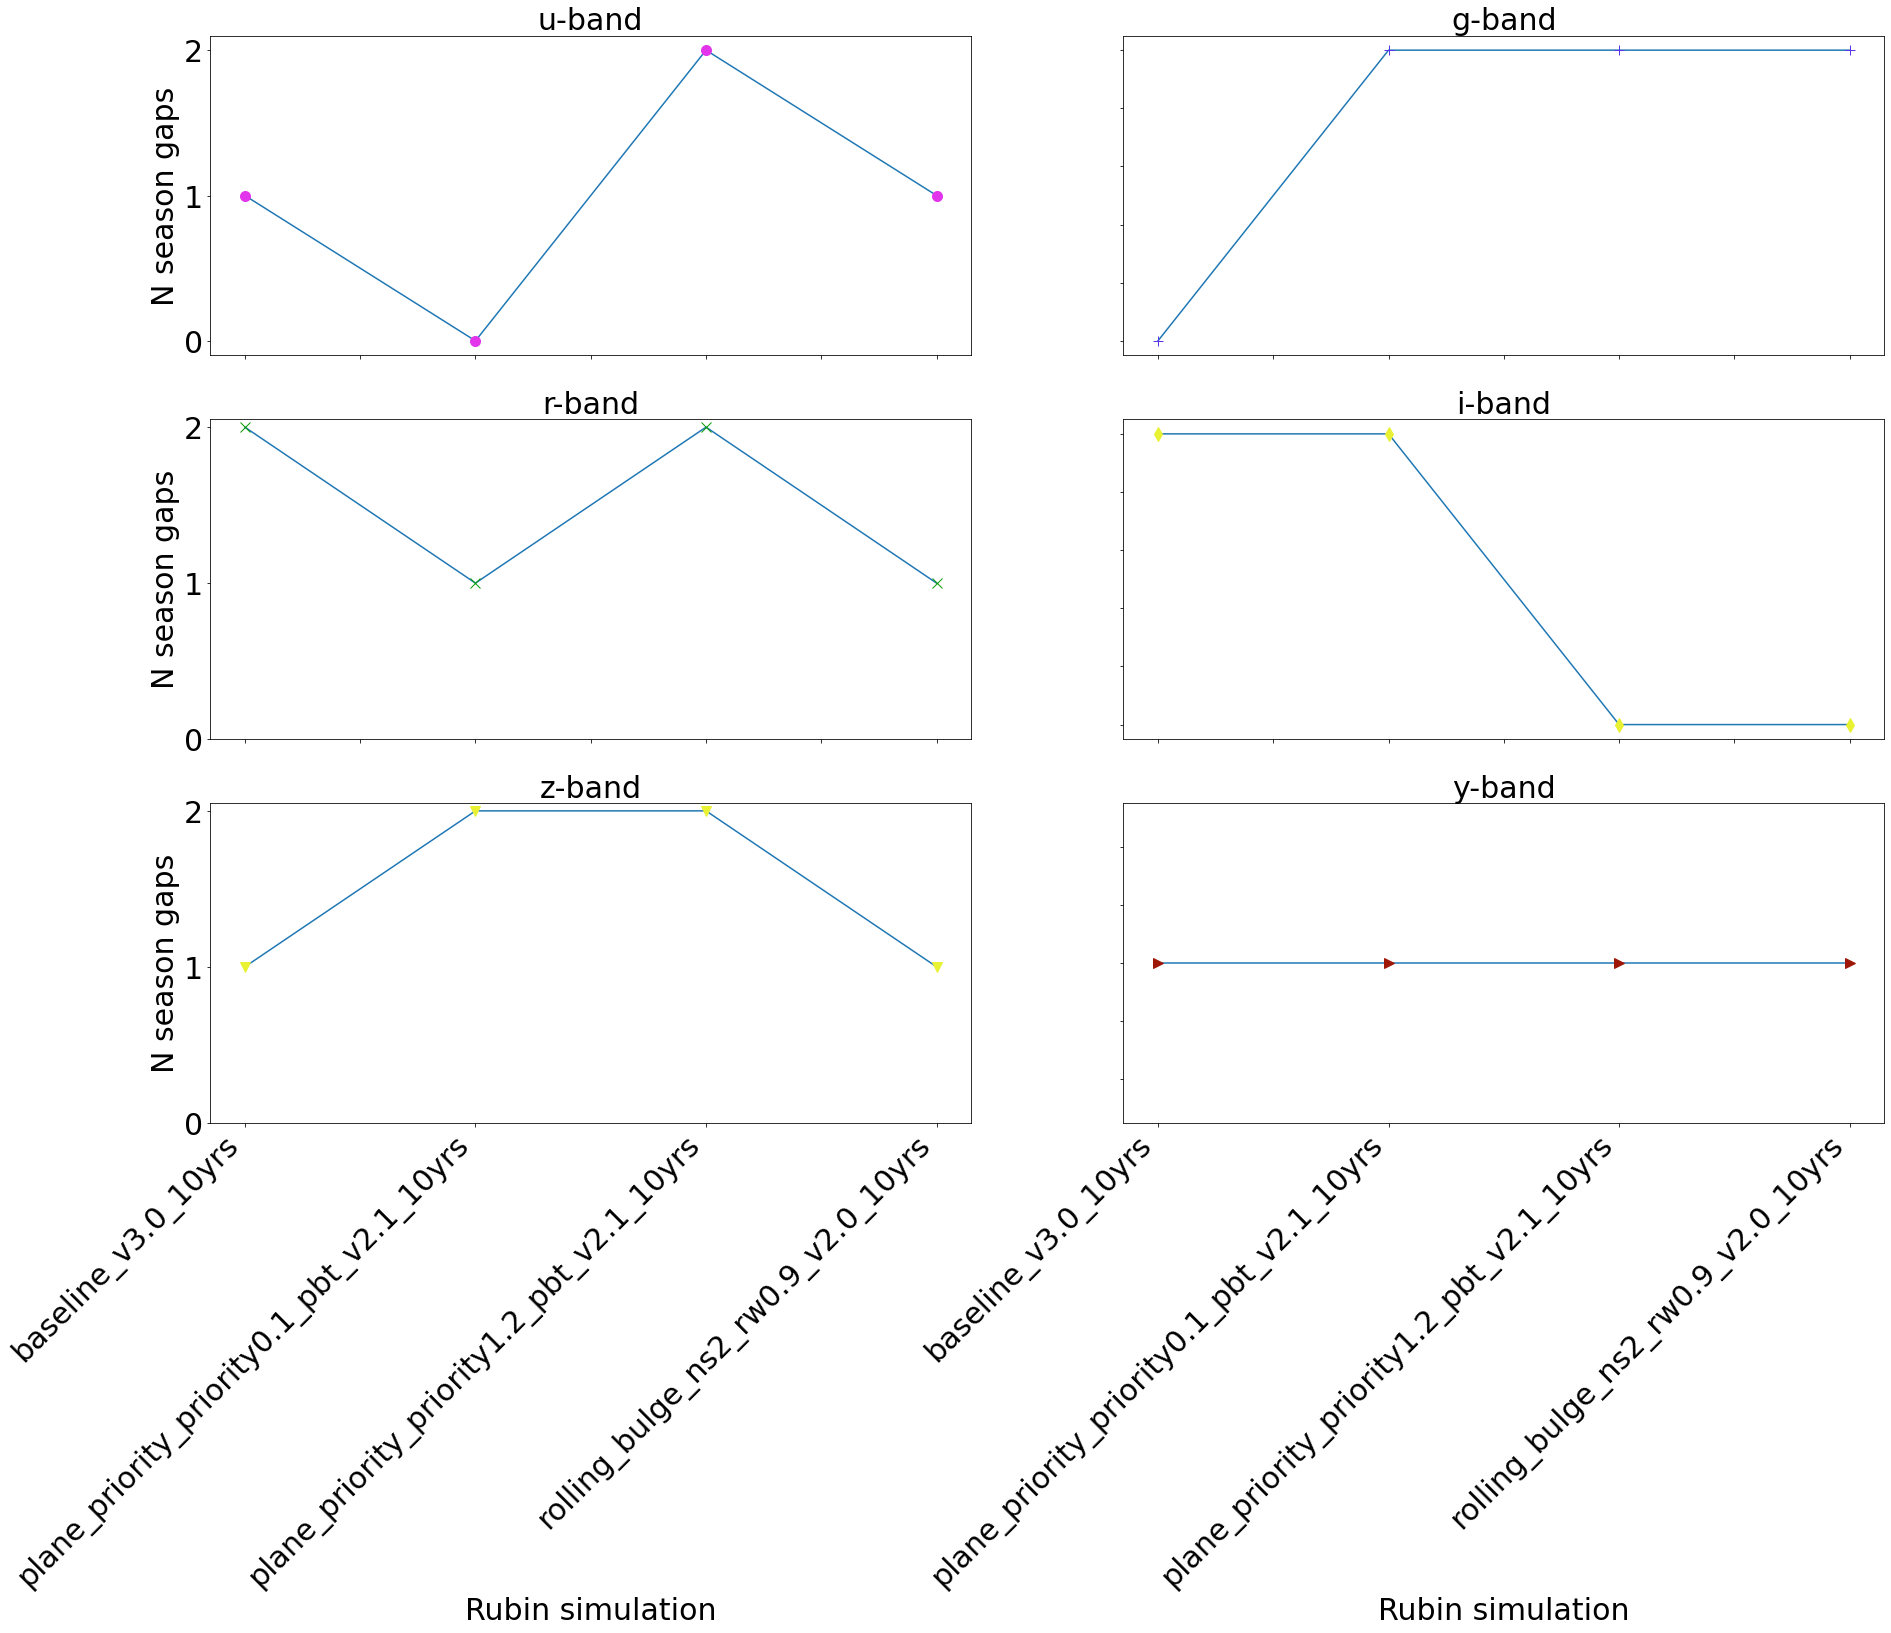

In [133]:
filter_symbols = {'u': 'o', 'g': '+', 'r': 'x', 'i': 'd', 'z': 'v', 'y': '>'}
filter_colors = {'u': '#e134eb',
                 'g': '#5934eb',
                 'r': '#099e06',
                 'i': '#e8f233',
                 'z': '#e8f233',
                 'y': '#9e1606'}
fontsize = 20

# Sort the list of opsims into alphabetical order
opsim_list = list(metric_data.keys())
opsim_list.sort()

# Build a list of the Roman season gaps to use as axis labels
ngaps = len(roman_survey.season_gaps)
seasongap_list = []
for gap in roman_survey.season_gaps:
    label = str(gap['start']).split('T')[0]+' - '+str(gap['end']).split('T')[0]
    seasongap_list.append(label)

nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(10*nrow,10*ncol), facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

fontsize = 30

irow = 0
icol = -1
for f,bandpass in enumerate(['u','g','r','i','z','y']):
    icol += 1
    if icol >= ncol:
        icol = 0
        irow += 1
    ax = axs[irow,icol]
    
    # Extract the data from all opsims
    xdata = np.arange(0,len(opsim_list),1)
    ydata = []
    for i,runName in enumerate(opsim_list):
        ydata.append(metric_data[runName][bandpass]['ngaps_monitored'])
    
    # Plot the scatter chart
    ax.plot(xdata, ydata, 
            marker=filter_symbols[bandpass], mfc=filter_colors[bandpass], mec=filter_colors[bandpass],
            markersize=10)
    
    # Include x-axis labels for the bottom row plots only
    if irow == nrow-1:
        xticks = np.arange(0,len(opsim_list),1)
        ax.set_xticks(xticks)
        ax.set_xticklabels(opsim_list, rotation=45.0,horizontalalignment='right',fontsize=fontsize)
        ax.set_xlabel('Rubin simulation', fontsize=fontsize)
    else:
        ax.set_xticklabels([])
        
    # Include y-axis labels for the first column plots only
    if icol == 0:
        yticks =  ax.get_yticks()
        yticks = np.arange(0,yticks.max(),1)
        yticklabels = [str(int(x)) for x in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, fontsize=fontsize)
        ax.set_ylabel('N season gaps', fontsize=fontsize)
    else:
        ax.set_yticklabels([])
        
    ax.set_title(bandpass+'-band', fontsize=fontsize)

display = True
if display:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig('/Users/rstreet1/Roman/CoreSurveyWhitePaper/roman_rubin_ngaps_covered.png')
    plt.close(1)